# MAC0318 Introdução à Programação de Robôs Móveis

## Controlador por aprendizado de redes neurais convolucionais

Vamos construir novamente um regressor baseado em redes neurais para prever a saída do sistema de controle do robô seguidor de pisa a partir de imagens da câmera do robô. A saída do nosso modelo é portanto uma estimativa para

$$
y(t) = 6d(t) + \alpha(t) .
$$

onde $d$ e $\alpha$ são dados como na figura abaixo.

<figure style="text-align: center">
    <img src="img/lane_following2.png" width=300>
</figure>

Vamos modificar a arquitetura que usamos anteriormente para incluir camadas convolucionais que permitam atingir desempenho similar com um número muito menor de parâmetros e sem segmentação de cores.

## Pré-processamento de imagem

Vamos carregar os dados com as imagens pré-processadas (redimensionadas e com a porção acima da linha do horizonte descartada). Apesar da segmentação por cores tornar o modelo mais robusto à mudanças do ambiente e facilitar o aprendizado, vamos aprender um regressor diretamente das imagens no espaço RGB.

In [1]:
# Começamos carregando as bibliotecas necessárias

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import gc

### Obtendo o conjunto de dados

Vamos utilizar os mesmos conjuntos de [dados de imagens](https://drive.google.com/file/d/1n9uitBceCk4xXEJ7njoKWFMXpNegySDQ/view?usp=sharing) e os respectivos [valores de saída](https://drive.google.com/file/d/1yVujNH-Hd7ifqKrgAe6XscawdhDVkn_f/view?usp=sharing) $y=6d+\alpha$.
Baixe os arquivos (se já não os tiver em seu computador) e modifique os caminhos abaixo de maneira adequada.

In [2]:
# Mude os endereços dos arquivos conforme necessário
images = np.load('data-lane-pose-estimation-images.npy', allow_pickle=True) 
print('Dimensões das imagens:', images.shape) # dimensões do conjunto de imagens: número de exemplos e dimensões de cada imagem
y_true = np.load('data-lane-pose-estimation-labels.npy', allow_pickle=True) 
print('Dimensões das saídas:', y_true.shape) # dimensões do conjunto de saídas: número de exemplos

Dimensões das imagens: (3775, 42, 80, 3)
Dimensões das saídas: (3775,)


Vamos normalizar as imagens para que os pixels sejam valores reais no intervalo $[0,1]$ com precisão de 32 bits.

In [3]:
X = (images/255.0).astype(np.float32)

Vamos ver a primeira imagem do conjunto e suas saída

Dimensões: 80x42 pixels


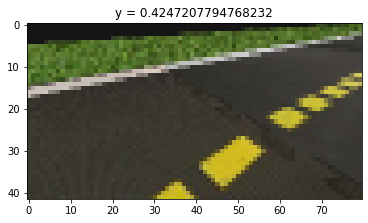

In [4]:
img, y = X[0], y_true[0]
plt.imshow(img);
plt.title(f'y = {y}')
print(f'Dimensões: {img.shape[1]}x{img.shape[0]} pixels')

### Separação treino-teste

Particionamos os dados entre:

1. **Treino**: Usado para selecionar ou ajustar os parâmetros do modelo para obter uma acurácia alta.
2. **Teste**: Usado para estimar a acurácia do modelo em dados reais *não vistos*.

In [5]:
p = 0.9 # proporção do tamanho do subconjunto de treino
N_treino = int(p*X.shape[0] + 0.5) # quantidade de exemplos de treino

# Permutamos os índices dos exemplos
indices = np.random.permutation(X.shape[0])
id_treino, id_teste = indices[:N_treino], indices[N_treino:]
X_treino, X_teste = X[id_treino,:,:,:], X[id_teste,:,:,:]
y_treino, y_teste = y_true[id_treino], y_true[id_teste]

print(f'Proporção de treino: {X_treino.shape[0]/X.shape[0]:.4f}')

Proporção de treino: 0.9001


##  Treinamento

Podemos finalmente aprender uma rede neural para a tarefa -- Precisamos escolher a arquitetura da rede e os hiperparâmetros.

In [6]:
# Ter uma GPU ajuda bastante, mas não é crucial para esse exemplo pequeno
# Lembre-se: você pode recorrer ao Google Colaboratory para treinar a rede se precisar
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  []


### Arquitetura

Vamos usar uma arquitetura simples com 5 camadas ocultas.

As três primeiras camadas farão a extração das características e serão do [tipo convolucional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). As últimas duas camadas servirão para construir um regressor não linear a partir das características extraídas e serão do tipo densas. Como anteriormente, diminuímos os tamanhos das camadas a medida que avançamos rumo a saída de forma a encorjar representações dos dados cada vez mais abstratas por meio de compressão de informação.

Você pode experimentar com arquiteturas diferentes e analisar o impacto no desempenho.

In [7]:
# Especifiamos e compilamos uma rede sem camadas ocultas

dimensão = X[0].size # tamanho total da entrada 

gc.collect() # vamos limpar a memória antes de construir o modelo (pois ele usa bastante memória)

modelo = keras.Sequential([
    keras.Input(shape=X[0].shape), # camada de entrada   # As primeiras 
    # Vamos começar por uma camada convolucional com 16 filtros convolucionais, kernel 3x3, sem padding e com passo (stride) 1
    layers.Conv2D(16, kernel_size=3, strides=(1, 1), activation='leaky_relu'), 
    # Seguida por uma camada convolucional com 8 filtros, kernel 3x3, sem padding e com passo 2
    layers.Conv2D(8, kernel_size=3, strides=(2, 2), activation='relu'), 
    # E por fim uma camada convolucional com 2 filtros, kernel 3x3, sem padding e com passo 2
    layers.Conv2D(2, kernel_size=3, strides=(2, 2), activation='relu'), 
    # "Achatamos" a entrada para a camada densa, que recebe um vetor
    layers.Flatten(),                                    
    # Camada densa para realizar a regressão não linear
    layers.Dense(16, activation='leaky_relu'),
    # Última camada realiza regressão linear a partir da representação da camada anterior
    layers.Dense(1) # Camada de saída
  ])
# Vamos utilizar Adam e medir o desempenho também pelo erro absoluto médio
modelo.compile(loss='mean_squared_error', optimizer='Adam', metrics= ['mean_squared_error'])

Resumo do modelo que criamos -- compare o número de parâmetros com a rede densa da atividade anterior

In [8]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 78, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 76, 8)         1160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 74, 2)         146       
_________________________________________________________________
flatten (Flatten)            (None, 5328)              0         
_________________________________________________________________
dense (Dense)                (None, 16)                85264     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 87,035
Trainable params: 87,035
Non-trainable params: 0
____________________________________________________

Agora otimimizamos o modelo -- Note: **esse processo usar recursos consideráveis do seu computador**, isto é, memória e tempo de processamento. Se seu computador não tiver recursos, considere usar o Google Collab.

In [9]:
num_epochs = 60 # número de épocas (iterações) so aprendizado -- quanto menos parâmetros menos iterações precisamos

class PrintDot(keras.callbacks.Callback):
    'Mostra progresso do aprendizado.'
    def on_epoch_end(self, epoch, logs):
        if epoch % 30 == 0: print(f'{100*epoch/num_epochs:.0f}%', end='') # mostrar % de progresso a cada 30 épocas
        elif epoch % 5 == 0: print('.', end='')  # mostrar ponto a cada 5 épocas    

# Chama função de aprendizado -- isso demora alguns minutos!
hist = modelo.fit( 
    X_treino,                   # conjunto de entrada
    y_treino.astype('float32'), # conjunto de saída -- precisamos reduzir a precisão numérica da saída também para manter consistência
    epochs = num_epochs,        # número de épocas
    validation_split = 0.1,     # separar porção dos dados para servir como validação
    verbose = 0,                # 0, 1 ou 2, regulam a quantidade de feedback fornecido (verborragia)
    batch_size = 128,            # vamos usar amostras do conjunto de treino para economizar memória e prevenir overfitting
                                # - diminuir esse número reduz o uso de memória, porém diminui a convergência e estabilidade
    callbacks=[PrintDot()]      # Vamos usar pontinhos para indicar o progresso
)

print('100%')

0%.....30%.....60%.....90%.100%


Observe a curva de aprendizado; esperamos que ele tenha uma tendência de queda abrupta no começo para valores abaixo de 0.01 nas primeiras épocas e em seguida mantenha-se em uma pequena queda. O erro de validação serve para se assegurar que o modelo não está superajustado aos dados de treino e que portanto sua acurácia *generaliza* para à população.

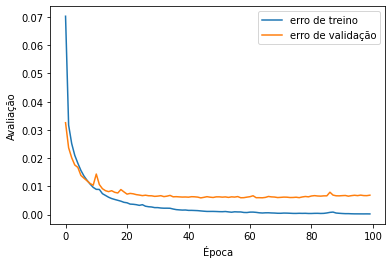

In [10]:
plt.plot(hist.epoch, hist.history['loss'], label='erro de treino');
plt.plot(hist.epoch, hist.history['val_loss'], label='erro de validação');
plt.xlabel('Época');
plt.ylabel('Avaliação');
plt.legend();

### E se meu preditor é ruim?

Você pode tentar melhorar a qualidade do seu preditor:

1. Realizando novamente o aprendizado a partir de outro solução inicial (aleatória)
2. Aumentanto a quantidade de camadas convolucionais da rede ou a quantidade de filtros por camada
3. Aumentando o número de épocas de treino
4. Aumentando o tamanho do _minibatch_
5. Modificando o algoritmo de aprendizado (RMSProp é outro algoritmo comumente utilizado)

## Teste sua rede

Antes de anunciarmos o problema como resolvido, precisamos nos assegurar que os resultados serão replicados em  dados futuros. Para isso vamos medir a qualidade do modelo no conjunto de teste que separamos.

In [11]:
# Calcular erro médio no conjunto de teste
y_pred = modelo.predict(X_teste).flatten() 
mse = ((y_pred - y_teste)**2).sum()/y_pred.size
print('MSE:', mse)

MSE: 0.0035793918368410946


Você deve observar se o erro médio no conjunto de teste é similar ao observado no conjunto de validação e no de treino. Uma forma mais rigorosa de atestar semelhança seria construindo intervalos de confiança para os estimadores. Nessa atividade vamos nos satisfazer com uma análise qualitativa subjetiva apenas.

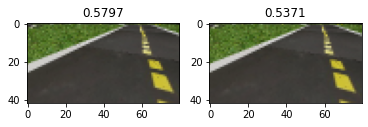

In [17]:
k = 0 # índice de exemplo -- mude para ver outro caso
fig, ax = plt.subplots(1,2)
ax[0].imshow(X_teste[k]); 
ax[0].set_title(f'{y_teste[k]:.4f}');
ax[1].imshow(X_teste[k]); 
ax[1].set_title(f'{y_pred[k]:.4f}');